# 概要

* 関連する掲示板の一覧を取得し、保存する
  * 欲しい情報
    * スレタイ
    * close日時
    * リンク
* ココ使う：https://find.open2ch.net/

# 初期設定

In [1]:
import re
import time
import datetime
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests

# 各種関数準備

In [2]:
# 文字列から日付のみ抽出し、datetime型にして返す関数
def format_date(str_date):
    m = re.search(r'[0-9]{4}/[0-9]{2}/[0-9]{2} [0-9]{2}:[0-9]{2}', str_date)
    return datetime.datetime.strptime(m.group(), '%Y/%m/%d %H:%M')

format_date('携帯電話ゲー\n2020/11/13 10:47')

datetime.datetime(2020, 11, 13, 10, 47)

In [8]:
# 検索ページのurlをもらったら、タイトル一覧、日付一覧、リンク一覧を返す関数
def get_boards_info(url):
    # ページの情報取得
    time.sleep(1)
    html = requests.get(url).text
    soup = BeautifulSoup(html,'html.parser')
    
    # 各掲示板の情報
    results = soup.find_all(class_='result')
    # タイトル一覧
    subjects = [result.find(class_='subject').find('a').text for result in results]
    # 日付一覧
    dates = [result.find(class_='content').text for result in results]
    # リンク一覧
    links = [result.find(class_='subject').find('a').get('href') for result in results]
    
    # データととのえる
    # 日付を文字列からdatetime型へ
    dates = list(map(format_date, dates))
    # リンク末尾のl50を消す
    links = list(map(lambda x: re.match(r'.+(?=l50)', x).group(), links))
    
    return {
        'スレタイ': subjects,
        '日付': dates,
        'リンク': links,
    }

In [16]:
# 検索ページのurlをもらったら、タイトル、日付、リンク一覧のデータフレームを返す関数
def get_boards_dataframe(y, url):
    # 情報取得
    boards_info = get_boards_info(url)
    # データフレーム作る
    df = pd.DataFrame(boards_info)
    return df

# データ取得

## 各年の最後のスレタイ確認（xx人目）

In [10]:
# urlのリストつくる
def make_url(y):
    return f'https://find.open2ch.net/?bbs=appli&t=&q=%EF%BD%BC%EF%BE%9D%EF%BE%83%EF%BE%9E%EF%BE%9A%EF%BE%97%EF%BD%B6%EF%BE%9E%EF%BD%B0%EF%BE%99%EF%BD%BD%EF%BE%9E+%E4%BA%BA%E7%9B%AE&wh=&kako=checked&d={y}'

urls = {y: make_url(y) for y in [2014, 2015, 2016, 2017, 2018, 2019]}
# 最新年だけは年でフィルタかけられない
urls[2020] = 'https://find.open2ch.net/?bbs=appli&t=&q=%EF%BD%BC%EF%BE%9D%EF%BE%83%EF%BE%9E%EF%BE%9A%EF%BE%97%EF%BD%B6%EF%BE%9E%EF%BD%B0%EF%BE%99%EF%BD%BD%EF%BE%9E&wh=&d='
urls

{2014: 'https://find.open2ch.net/?bbs=appli&t=&q=%EF%BD%BC%EF%BE%9D%EF%BE%83%EF%BE%9E%EF%BE%9A%EF%BE%97%EF%BD%B6%EF%BE%9E%EF%BD%B0%EF%BE%99%EF%BD%BD%EF%BE%9E+%E4%BA%BA%E7%9B%AE&wh=&kako=checked&d=2014',
 2015: 'https://find.open2ch.net/?bbs=appli&t=&q=%EF%BD%BC%EF%BE%9D%EF%BE%83%EF%BE%9E%EF%BE%9A%EF%BE%97%EF%BD%B6%EF%BE%9E%EF%BD%B0%EF%BE%99%EF%BD%BD%EF%BE%9E+%E4%BA%BA%E7%9B%AE&wh=&kako=checked&d=2015',
 2016: 'https://find.open2ch.net/?bbs=appli&t=&q=%EF%BD%BC%EF%BE%9D%EF%BE%83%EF%BE%9E%EF%BE%9A%EF%BE%97%EF%BD%B6%EF%BE%9E%EF%BD%B0%EF%BE%99%EF%BD%BD%EF%BE%9E+%E4%BA%BA%E7%9B%AE&wh=&kako=checked&d=2016',
 2017: 'https://find.open2ch.net/?bbs=appli&t=&q=%EF%BD%BC%EF%BE%9D%EF%BE%83%EF%BE%9E%EF%BE%9A%EF%BE%97%EF%BD%B6%EF%BE%9E%EF%BD%B0%EF%BE%99%EF%BD%BD%EF%BE%9E+%E4%BA%BA%E7%9B%AE&wh=&kako=checked&d=2017',
 2018: 'https://find.open2ch.net/?bbs=appli&t=&q=%EF%BD%BC%EF%BE%9D%EF%BE%83%EF%BE%9E%EF%BE%9A%EF%BE%97%EF%BD%B6%EF%BE%9E%EF%BD%B0%EF%BE%99%EF%BD%BD%EF%BE%9E+%E4%BA%BA%E7%9B%AE&wh=&kako=ch

In [ ]:
for y, url in urls.items():
    print(y, url)
    # データフレーム入手
    df = get_boards_dataframe(y, url)
    display(df.head())

| year |  last(x人目) |
|-----:|------:|
| 2014 |   377 |
| 2015 |  1907 |
| 2016 |  5170 |
| 2017 |  8900 |
| 2018 | 12658 |
| 2019 | 17168 |
| 2020 | 21149? |


## 年、x人目を指定しながら検索していく

### 関数準備

In [11]:
# y年、num人目で検索するurlをつくる関数
def make_url_num(y, num):
    # 2020年は年指定して検索できない（2020/11/15時点）
    if y == 2020:
        return f'https://find.open2ch.net/?bbs=appli&t=&q=%EF%BD%BC%EF%BE%9D%EF%BE%83%EF%BE%9E%EF%BE%9A%EF%BE%97%EF%BD%B6%EF%BE%9E%EF%BD%B0%EF%BE%99%EF%BD%BD%EF%BE%9E+{num}%E4%BA%BA%E7%9B%AE&wh=&d='
    else:
        return f'https://find.open2ch.net/?bbs=appli&t=&q=%EF%BD%BC%EF%BE%9D%EF%BE%83%EF%BE%9E%EF%BE%9A%EF%BE%97%EF%BD%B6%EF%BE%9E%EF%BD%B0%EF%BE%99%EF%BD%BD%EF%BE%9E+{num}%E4%BA%BA%E7%9B%AE&wh=&kako=checked&d={y}'    

In [18]:
# 年を指定したら、タイトル、日付、リンク一覧のデータフレームを保存する関数
def save_boards_list(y, years):
    dfs = []
    for num in years[y]:
        # 進行状況
        if num % 100 == 0:
            print(num)
        # 検索するurl
        url = make_url_num(y, num)
        # データフレーム入手
        dfs.append(get_boards_dataframe(y, url))

    # 結合
    df = pd.concat(dfs, axis=0, ignore_index=True)
    # 年でフィルタ
    df = df[df['日付'].apply(lambda x: x.year) == y]
    # スレタイでフィルタ
    df = df[df['スレタイ'].str.match('【mobage】.+ｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ.+人目.+')]
    # 重複があったら削除
    df.drop_duplicates(inplace=True)
    print('保存')
    df.to_pickle('data/' + f'list_{y}.pkl')

### データ取得

In [13]:
# 各年の最終スレタイ（x人目）
ends = {
    2013: 0,
    2014: 377,
    2015: 1907,
    2016: 5170,
    2017: 8900,
    2018: 12658,
    2019: 17168,
    2020: 21149,
}

In [14]:
# 年ごとの検索範囲設定
years = {y: range(ends[y-1]+1, ends[y] + 1) for y in range(2014, 2021)}
years

{2014: range(1, 378),
 2015: range(378, 1908),
 2016: range(1908, 5171),
 2017: range(5171, 8901),
 2018: range(8901, 12659),
 2019: range(12659, 17169),
 2020: range(17169, 21150)}

In [19]:
y = 2019
save_boards_list(y, years)

12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
保存


# 保存したデータ確認

In [26]:
# 確認
y = 2019
df = pd.read_pickle('data/' + f'list_{y}.pkl')
df

,スレタイ,日付,リンク
0,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ12671人目(あけおめサチコンマ)...,2019-01-01 00:10:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...
1,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ12672人目(カワイイサチコンマ)...,2019-01-01 01:07:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...
2,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ12673人目(カワイイサチコンマ)...,2019-01-01 02:26:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...
3,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ12674人目(1000),2019-01-01 07:55:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...
4,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ12675人目(1000),2019-01-01 10:07:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...
...,...,...,...
4478,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ17164人目(1000),2019-12-31 20:29:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...
4479,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ17165人目【ご報告乱舞コンマ】(...,2019-12-31 21:12:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...
4480,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ17166人目【比奈コンマ】(1001),2019-12-31 21:57:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...
4481,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ17167人目【今年最後の比奈コンマ...,2019-12-31 23:01:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...


In [27]:
df['month'] = df['日付'].apply(lambda x: x.month)
df

,スレタイ,日付,リンク,month
0,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ12671人目(あけおめサチコンマ)...,2019-01-01 00:10:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...,1
1,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ12672人目(カワイイサチコンマ)...,2019-01-01 01:07:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...,1
2,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ12673人目(カワイイサチコンマ)...,2019-01-01 02:26:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...,1
3,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ12674人目(1000),2019-01-01 07:55:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...,1
4,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ12675人目(1000),2019-01-01 10:07:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...,1
...,...,...,...,...
4478,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ17164人目(1000),2019-12-31 20:29:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...,12
4479,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ17165人目【ご報告乱舞コンマ】(...,2019-12-31 21:12:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...,12
4480,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ17166人目【比奈コンマ】(1001),2019-12-31 21:57:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...,12
4481,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ17167人目【今年最後の比奈コンマ...,2019-12-31 23:01:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...,12


In [28]:
df['day'] = df['日付'].apply(lambda x: x.day)
df

,スレタイ,日付,リンク,month,day
0,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ12671人目(あけおめサチコンマ)...,2019-01-01 00:10:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...,1,1
1,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ12672人目(カワイイサチコンマ)...,2019-01-01 01:07:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...,1,1
2,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ12673人目(カワイイサチコンマ)...,2019-01-01 02:26:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...,1,1
3,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ12674人目(1000),2019-01-01 07:55:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...,1,1
4,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ12675人目(1000),2019-01-01 10:07:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...,1,1
...,...,...,...,...,...
4478,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ17164人目(1000),2019-12-31 20:29:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...,12,31
4479,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ17165人目【ご報告乱舞コンマ】(...,2019-12-31 21:12:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...,12,31
4480,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ17166人目【比奈コンマ】(1001),2019-12-31 21:57:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...,12,31
4481,【mobage】アイドルマスターｼﾝﾃﾞﾚﾗｶﾞｰﾙｽﾞ17167人目【今年最後の比奈コンマ...,2019-12-31 23:01:00,https://hayabusa3.open2ch.net/test/read.cgi/ap...,12,31


In [29]:
df.groupby('month')['スレタイ'].count()

month
1     244
2     327
3     334
4     331
5     393
6     357
7     394
8     374
9     378
10    396
11    381
12    374
Name: スレタイ, dtype: int64

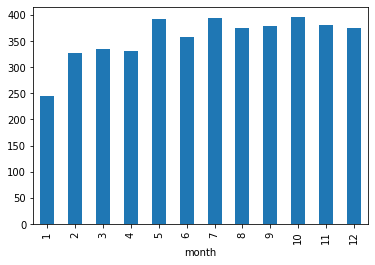

In [30]:
df.groupby('month')['スレタイ'].count().plot(kind='bar')

In [31]:
df.groupby('day')['スレタイ'].count()

day
1     143
2     136
3     142
4     148
5     133
6     133
7     138
8     145
9     150
10    139
11    140
12    141
13    138
14    141
15    136
16    145
17    141
18    133
19    141
20    142
21    147
22    146
23    141
24    131
25    125
26    146
27    145
28    143
29    130
30    137
31     87
Name: スレタイ, dtype: int64

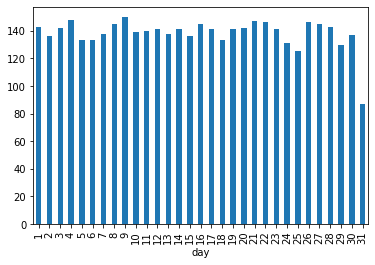

In [32]:
df.groupby('day')['スレタイ'].count().plot(kind='bar')